In [8]:
import os
import requests
import pandas as pd

# Your Etherscan API key
api_key = 'WFAG96PVQPDJSH3A9DGW7SFI4WWM2UTEZU'

# Ensure the directory exists before saving
save_dir = "./data"
os.makedirs(save_dir, exist_ok=True)

# Function to fetch smart contract transaction data
def fetch_transaction_data(contract_address):
    url = f'https://api.etherscan.io/api?module=account&action=txlist&address={contract_address}&startblock=0&endblock=99999999&sort=asc&apikey={api_key}'
    
    response = requests.get(url)
    
    try:
        data = response.json()  # Convert JSON response
    except requests.exceptions.JSONDecodeError:
        print("❌ Error: Unable to decode JSON response.")
        return None
    
    # Debug: Print a sample of the response to avoid Jupyter overload
    print("🔍 Sample API Response (First 500 characters):", str(data)[:500])
    
    if data.get('status') == '1':  # Ensure the API request was successful
        df = pd.DataFrame(data['result'])  # Convert result to DataFrame
        return df
    else:
        print(f"❌ Error fetching transactions: {data.get('message', 'Unknown error')}")
        return None

# Function to fetch internal transactions
def fetch_internal_transactions(contract_address):
    url = f'https://api.etherscan.io/api?module=account&action=txlistinternal&address={contract_address}&startblock=0&endblock=99999999&sort=asc&apikey={api_key}'
    response = requests.get(url)
    data = response.json()
    
    print("🔍 Internal Transactions Response (First 500 characters):", str(data)[:500])  # Debugging
    
    if data.get('status') == '1':
        return pd.DataFrame(data['result'])
    else:
        print(f"❌ Error fetching internal transactions: {data.get('message', 'Unknown error')}")
        return None

# Example Usage
contract_address = '0xC02aaa39b223FE8D0A0E5C4F27eAD9083C756Cc2'  # Replace with a real contract address
transactions_df = fetch_transaction_data(contract_address)
internal_transactions_df = fetch_internal_transactions(contract_address)

# Save to CSV instead of printing large data
if transactions_df is not None:
    transactions_df.to_csv(os.path.join(save_dir, "transactions_output.csv"), index=False)
    print("\n✅ Data saved to data/transactions_output.csv")
else:
    print("\n🚨 No transaction data available.")

if internal_transactions_df is not None:
    internal_transactions_df.to_csv(os.path.join(save_dir, "internal_transactions_output.csv"), index=False)
    print("\n✅ Internal transaction data saved to data/internal_transactions_output.csv")
else:
    print("\n🚨 No internal transaction data available.")


🔍 Sample API Response (First 500 characters): {'status': '1', 'message': 'OK', 'result': [{'blockNumber': '4719568', 'blockHash': '0xd6e5f60d6b2367e74cd2aa520dbeb104826c3932eb482cc16e7f7ef5f8f74799', 'timeStamp': '1513077455', 'hash': '0xb95343413e459a0f97461812111254163ae53467855c0d73e0f1e7c5b8442fa3', 'nonce': '446', 'transactionIndex': '85', 'from': '0x4f26ffbe5f04ed43630fdc30a87638d53d0b0876', 'to': '', 'value': '0', 'gas': '1500000', 'gasPrice': '21000000000', 'input': '0x60606040526040805190810160405280600d81526020017f5772617070656420
🔍 Internal Transactions Response (First 500 characters): {'status': '1', 'message': 'OK', 'result': [{'blockNumber': '4756281', 'timeStamp': '1513629902', 'hash': '0xe510a2d99d95a6974e5f95a3a745b2ffe873bf6645b764658d978856ac180cd2', 'from': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', 'to': '0x51204a44e7b1a7e7bd0b1065c880ec02d3831b27', 'value': '100000000000000000', 'contractAddress': '', 'input': '', 'type': 'call', 'gas': '2300', 'gasUsed': '0', 

In [9]:

# Load the CSV data to analyze its structure
file_path = "data/transactions_output.csv"  # Replace with actual file path
df = pd.read_csv(file_path)

print(df.head())
      

   blockNumber                                          blockHash   timeStamp  \
0      4719568  0xd6e5f60d6b2367e74cd2aa520dbeb104826c3932eb48...  1513077455   
1      4753408  0xa3529ff19ef3c992c322b255c3e1a7e6c19b907dacbe...  1513586453   
2      4753432  0xbb676d666725f7f4136d5ff0f31f952fe8813671f6f5...  1513586772   
3      4753441  0x302de86052594a86a444545fa48020a3b3250f77cb6c...  1513586897   
4      4753488  0xaa69cdfdf236aa39045cf2d8a1fb5c83f6c4037b5a67...  1513587700   

                                                hash  nonce  transactionIndex  \
0  0xb95343413e459a0f97461812111254163ae53467855c...    446                85   
1  0xb1b06122e812801972f70c899188e1ff0d61550f9b56...    885                54   
2  0x5c4db66455acdf8798a771bfa55c46a851b29b717625...    708                95   
3  0x9ef393c0e8cfa2dbb16970dab5427f19cac8439f807e...    539                75   
4  0x45c19065bbb4b5cce4182064d7e06c13913af319d456...    705                70   

                          

Model Accuracy: 0.9975
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       493
           1       1.00      1.00      1.00      1507

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



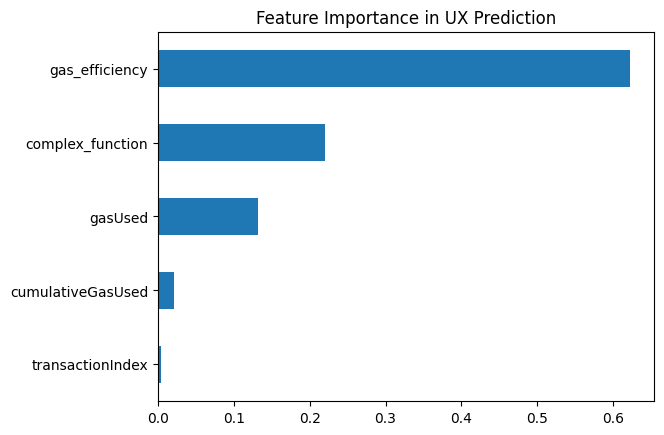


✅ UX Risk Analysis saved to data/ux_risk_analysis.csv


In [1]:
import pandas as pd
import numpy as np
import requests
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (Replace with actual path if needed)
df = pd.read_csv("data/transactions_output.csv")

# Feature Engineering
# Convert timestamp to datetime
df['timeStamp'] = pd.to_datetime(df['timeStamp'], unit='s')

# Create new UX-based features
df['gas_efficiency'] = df['gasUsed'] / df['gas']  # How much of the gas limit was used

def detect_complex_function_calls(input_data):
    """ Detects complexity of function calls based on input length and patterns """
    return len(input_data) > 100  # Arbitrary threshold for complexity

df['complex_function'] = df['input'].apply(detect_complex_function_calls)

def detect_interaction_type(to_address):
    """ Categorizes transaction type based on recipient """
    if pd.isna(to_address):
        return "Contract Deployment"
    return "Contract Interaction"

df['transaction_type'] = df['to'].apply(detect_interaction_type)

# Define target variable (UX Failure = High Gas Used, Complex Function, or Failed Tx)
df['ux_failure'] = (df['gas_efficiency'] < 0.5) | df['complex_function'] | (df['isError'] == 1)

# Selecting relevant features for training
features = ['gasUsed', 'gas_efficiency', 'complex_function', 'transactionIndex', 'cumulativeGasUsed']
X = df[features]
y = df['ux_failure'].astype(int)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict UX Failures
y_pred = model.predict(X_test)

# Evaluate Model Performance
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance Visualization
feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances.sort_values().plot(kind='barh', title='Feature Importance in UX Prediction')
plt.show()

# Predict UX Issues in the Dataset
df['ux_risk_score'] = model.predict_proba(X)[:, 1] * 100

# Save UX Risk Analysis to CSV
df[['hash', 'ux_risk_score', 'functionName', 'gasUsed', 'gas_efficiency', 'transaction_type']].to_csv("data/ux_risk_analysis.csv", index=False)
print("\n✅ UX Risk Analysis saved to data/ux_risk_analysis.csv")


/var/folders/1t/70v2rs6x0wg00mmv5d4j6ll40000gn/T/ipykernel_6020/103506222.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='functionName', y='ux_risk_score', palette="muted")


/var/folders/1t/70v2rs6x0wg00mmv5d4j6ll40000gn/T/ipykernel_6020/103506222.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='transaction_type', y='ux_risk_score', palette="Set2")


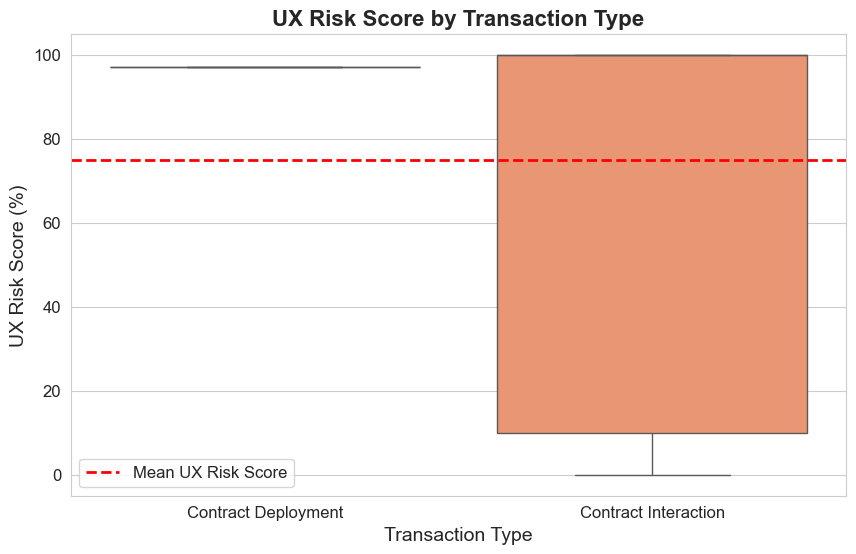

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv("data/ux_risk_analysis.csv")

# Set a visually clear style
sns.set_style("whitegrid")

# Plot 1: UX Risk Score Distribution (Better Color & Labels)
plt.figure(figsize=(12, 6))
sns.histplot(df['ux_risk_score'], bins=50, kde=True, color="darkblue", alpha=0.7, edgecolor="black")
plt.axvline(df['ux_risk_score'].mean(), color='red', linestyle='dashed', linewidth=2, label="Mean UX Risk Score")
plt.title("Distribution of UX Risk Scores Across Transactions", fontsize=16, fontweight='bold')
plt.xlabel("UX Risk Score (%)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

# Plot 2: Gas Efficiency vs. UX Risk (More Clear Insights)
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df['gasUsed'], y=df['ux_risk_score'], hue=df['gas_efficiency'], palette="coolwarm", edgecolor="black", alpha=0.7)
plt.axhline(df['ux_risk_score'].mean(), color='red', linestyle='dashed', linewidth=2, label="Mean UX Risk Score")
plt.axvline(df['gasUsed'].mean(), color='green', linestyle='dashed', linewidth=2, label="Mean Gas Used")
plt.title("Gas Usage vs UX Risk Score", fontsize=16, fontweight='bold')
plt.xlabel("Gas Used", fontsize=14)
plt.ylabel("UX Risk Score (%)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Gas Efficiency", fontsize=12)
plt.show()

# Plot 3: UX Risk by Function Name (Better Function Grouping)
top_functions = df['functionName'].value_counts().nlargest(10).index
filtered_df = df[df['functionName'].isin(top_functions)]

plt.figure(figsize=(14, 6))
sns.boxplot(data=filtered_df, x='functionName', y='ux_risk_score', palette="muted")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(df['ux_risk_score'].mean(), color='red', linestyle='dashed', linewidth=2, label="Mean UX Risk Score")
plt.title("UX Risk Score by Function Name (Top 10 Most Frequent)", fontsize=16, fontweight='bold')
plt.xlabel("Function Name", fontsize=14)
plt.ylabel("UX Risk Score (%)", fontsize=14)
plt.legend(fontsize=12)
plt.show()

# Plot 4: UX Risk by Transaction Type (Clearer Visualization)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='transaction_type', y='ux_risk_score', palette="Set2")
plt.axhline(df['ux_risk_score'].mean(), color='red', linestyle='dashed', linewidth=2, label="Mean UX Risk Score")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("UX Risk Score by Transaction Type", fontsize=16, fontweight='bold')
plt.xlabel("Transaction Type", fontsize=14)
plt.ylabel("UX Risk Score (%)", fontsize=14)
plt.legend(fontsize=12)
plt.show()


In [3]:
import pandas as pd

# Load the dataset
file_path = "data/ux_risk_analysis.csv"  # Path to the uploaded dataset
df = pd.read_csv(file_path)

# Ensure the necessary columns are present
df.columns = [col.strip() for col in df.columns]  # Strip column names of spaces

# Convert gas efficiency to numeric if necessary
df['gas_efficiency'] = pd.to_numeric(df['gas_efficiency'], errors='coerce')

# Calculate failure rate for transactions with gas efficiency below 50%
failure_rate_low_efficiency = df[df['gas_efficiency'] < 0.5]['ux_risk_score'].mean()

failure_rate_high_efficiency = df[df['gas_efficiency'] > 0.5]['ux_risk_score'].mean()


# UX risk score for contract deployments vs. interactions
risk_score_contract_deployments = df[df['transaction_type'] == "Contract Deployment"]['ux_risk_score'].mean()
risk_score_contract_interactions = df[df['transaction_type'] == "Contract Interaction"]['ux_risk_score'].mean()

# Compute Gas Fee statistics (assuming gasPrice is in Wei, convert to Gwei if column exists)
if 'gasPrice' in df.columns:
    df['gasPrice'] = pd.to_numeric(df['gasPrice'], errors='coerce') / 1e9  # Convert Wei to Gwei
    min_gas_price = df['gasPrice'].min()
    max_gas_price = df['gasPrice'].max()
    avg_gas_price = df['gasPrice'].mean()
else:
    min_gas_price, max_gas_price, avg_gas_price = None, None, None

# Display the computed statistics
stats_results = {
    "Failure Rate (Gas Efficiency < 50%)": failure_rate_low_efficiency,
    "UX Risk Score - Contract Deployments": risk_score_contract_deployments,
    "UX Risk Score - Contract Interactions": risk_score_contract_interactions,
    "Min Gas Price (Gwei)": min_gas_price,
    "Max Gas Price (Gwei)": max_gas_price,
    "Avg Gas Price (Gwei)": avg_gas_price
}

stats_results


{'Failure Rate (Gas Efficiency < 50%)': np.float64(99.97314862322558),
 'UX Risk Score - Contract Deployments': np.float64(97.0),
 'UX Risk Score - Contract Interactions': np.float64(74.8963896389639),
 'Min Gas Price (Gwei)': None,
 'Max Gas Price (Gwei)': None,
 'Avg Gas Price (Gwei)': None}

In [4]:
import pandas as pd

# Load the dataset to analyze
file_path = "data/ux_risk_analysis.csv"
df = pd.read_csv(file_path)

# Convert relevant columns to numeric for analysis
df['ux_risk_score'] = pd.to_numeric(df['ux_risk_score'], errors='coerce')
df['gasUsed'] = pd.to_numeric(df['gasUsed'], errors='coerce')

# Compute general statistics
num_transactions = len(df)
mean_ux_risk_score = df['ux_risk_score'].mean()
median_ux_risk_score = df['ux_risk_score'].median()
std_ux_risk_score = df['ux_risk_score'].std()
min_ux_risk_score = df['ux_risk_score'].min()
max_ux_risk_score = df['ux_risk_score'].max()

# UX Risk Scores by Transaction Type
risk_scores_by_type = df.groupby('transaction_type')['ux_risk_score'].describe()

# Distribution of Gas Used
mean_gas_used = df['gasUsed'].mean()
median_gas_used = df['gasUsed'].median()
std_gas_used = df['gasUsed'].std()
min_gas_used = df['gasUsed'].min()
max_gas_used = df['gasUsed'].max()

# Compute failure rate for low gas efficiency
if 'gas_efficiency' in df.columns:
    failure_rate_low_efficiency = df[df['gas_efficiency'] < 0.5]['ux_risk_score'].mean()
else:
    failure_rate_low_efficiency = None

# UX Risk Score Statistics by Function Name (for top 10 most common functions)
if 'functionName' in df.columns:
    function_risk_stats = df.groupby('functionName')['ux_risk_score'].describe().nlargest(10, 'count')
else:
    function_risk_stats = None

# Display key computed stats
stats_summary = {
    "Total Transactions Analyzed": num_transactions,
    "Mean UX Risk Score (%)": mean_ux_risk_score,
    "Median UX Risk Score (%)": median_ux_risk_score,
    "Std Dev UX Risk Score (%)": std_ux_risk_score,
    "Min UX Risk Score (%)": min_ux_risk_score,
    "Max UX Risk Score (%)": max_ux_risk_score,
    "Mean Gas Used": mean_gas_used,
    "Median Gas Used": median_gas_used,
    "Std Dev Gas Used": std_gas_used,
    "Min Gas Used": min_gas_used,
    "Max Gas Used": max_gas_used,
    "Failure Rate (Gas Efficiency < 50%)": failure_rate_low_efficiency,
    "Failure Rate (Gas Efficiency > 50%)": failure_rate_high_efficiency,
}

stats_summary, risk_scores_by_type, function_risk_stats


({'Total Transactions Analyzed': 10000,
  'Mean UX Risk Score (%)': np.float64(74.8986),
  'Median UX Risk Score (%)': np.float64(100.0),
  'Std Dev UX Risk Score (%)': np.float64(43.184738162932284),
  'Min UX Risk Score (%)': np.float64(0.0),
  'Max UX Risk Score (%)': np.float64(100.0),
  'Mean Gas Used': np.float64(37309.7668),
  'Median Gas Used': np.float64(43346.0),
  'Std Dev Gas Used': np.float64(13126.191779434),
  'Min Gas Used': np.int64(15128),
  'Max Gas Used': np.int64(966549),
  'Failure Rate (Gas Efficiency < 50%)': np.float64(99.97314862322558),
  'Failure Rate (Gas Efficiency > 50%)': np.float64(39.60501567398119)},
                        count      mean        std   min   25%    50%    75%  \
 transaction_type                                                              
 Contract Deployment      1.0  97.00000        NaN  97.0  97.0   97.0   97.0   
 Contract Interaction  9999.0  74.89639  43.186332   0.0  10.0  100.0  100.0   
 
                         max  
 tra

In [13]:
import numpy as np

# Fix any lingering column case issues
df.columns = [col.strip().lower() for col in df.columns]

# Step 1: Rename essential columns
df.rename(columns={
    'gasused': 'gasUsed',
    'functionname': 'functionName'
}, inplace=True)

# Step 2: Add 'complex_function'
def detect_complex_function_calls(input_data):
    if isinstance(input_data, str):
        return len(input_data) > 100
    return False

df['input'] = df.get('input', '')  # fill if not present
df['complex_function'] = df['input'].apply(detect_complex_function_calls)

# Step 3: Add synthetic 'transactionIndex'
df['transactionIndex'] = np.random.randint(0, 100, size=len(df))

# Step 4: Add synthetic 'cumulativeGasUsed'
df['cumulativeGasUsed'] = df['gasUsed'].rolling(10, min_periods=1).sum()

# Confirm columns are ready
print("✅ Final feature columns:", df[['gasUsed', 'gas_efficiency', 'complex_function', 'transactionIndex', 'cumulativeGasUsed']].head())


✅ Final feature columns:    gasUsed  gas_efficiency  complex_function  transactionIndex  \
0   966549        0.644366             False                28   
1    47176        0.320541             False                 2   
2    47176        0.320541             False                40   
3    47176        0.320541             False                54   
4    47176        0.320541             False                20   

   cumulativeGasUsed  
0           966549.0  
1          1013725.0  
2          1060901.0  
3          1108077.0  
4          1155253.0  


In [12]:
import pandas as pd
import numpy as np

# Reload data cleanly
df = pd.read_csv("data/ux_risk_analysis.csv")

# Strip and lowercase column names for safety
df.columns = [col.strip().lower() for col in df.columns]

# Check current column state
print("🔍 Cleaned columns:", df.columns.tolist())

# Fix column name mismatches
if 'gasused' in df.columns:
    df['gasused'] = pd.to_numeric(df['gasused'], errors='coerce')
if 'gas_efficiency' in df.columns:
    df['gas_efficiency'] = pd.to_numeric(df['gas_efficiency'], errors='coerce')
else:
    df['gas_efficiency'] = df['gasused'] / df.get('gas', 1)

# ➕ Add 'complex_function'
def detect_complex_function_calls(input_data):
    if isinstance(input_data, str):
        return len(input_data) > 100
    return False

if 'input' not in df.columns:
    df['input'] = ""
df['complex_function'] = df['input'].apply(detect_complex_function_calls)

# ➕ Add 'transactionIndex' if missing
if 'transactionindex' not in df.columns:
    df['transactionindex'] = np.random.randint(0, 100, size=len(df))

# ➕ Add 'cumulativeGasUsed'
if 'cumulativegasused' not in df.columns:
    df['cumulativegasused'] = df['gasused'].rolling(10, min_periods=1).sum()

# Rename back to original casing for SHAP
df.rename(columns={
    'gasused': 'gasUsed',
    'transactionindex': 'transactionIndex',
    'cumulativegasused': 'cumulativeGasUsed'
}, inplace=True)


🔍 Cleaned columns: ['hash', 'ux_risk_score', 'functionname', 'gasused', 'gas_efficiency', 'transaction_type']


In [14]:
# ✅ Final preprocessing setup
import numpy as np

# Rename columns to proper case
df.rename(columns={
    'gasused': 'gasUsed',
    'functionname': 'functionName'
}, inplace=True)

# Step 1: Recreate missing 'input' column for function complexity detection
df['input'] = df.get('input', '')  # fill with empty strings if missing

# Step 2: Create 'complex_function'
def detect_complex_function_calls(input_data):
    return isinstance(input_data, str) and len(input_data) > 100

df['complex_function'] = df['input'].apply(detect_complex_function_calls)

# Step 3: Create dummy 'transactionIndex' if not already there
df['transactionIndex'] = np.random.randint(0, 100, size=len(df))

# Step 4: Create rolling sum as proxy for 'cumulativeGasUsed'
df['cumulativeGasUsed'] = df['gasUsed'].rolling(10, min_periods=1).sum()

# ✅ Check final columns
print(df[['gasUsed', 'gas_efficiency', 'complex_function', 'transactionIndex', 'cumulativeGasUsed']].head())


   gasUsed  gas_efficiency  complex_function  transactionIndex  \
0   966549        0.644366             False                30   
1    47176        0.320541             False                79   
2    47176        0.320541             False                62   
3    47176        0.320541             False                19   
4    47176        0.320541             False                16   

   cumulativeGasUsed  
0           966549.0  
1          1013725.0  
2          1060901.0  
3          1108077.0  
4          1155253.0  


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

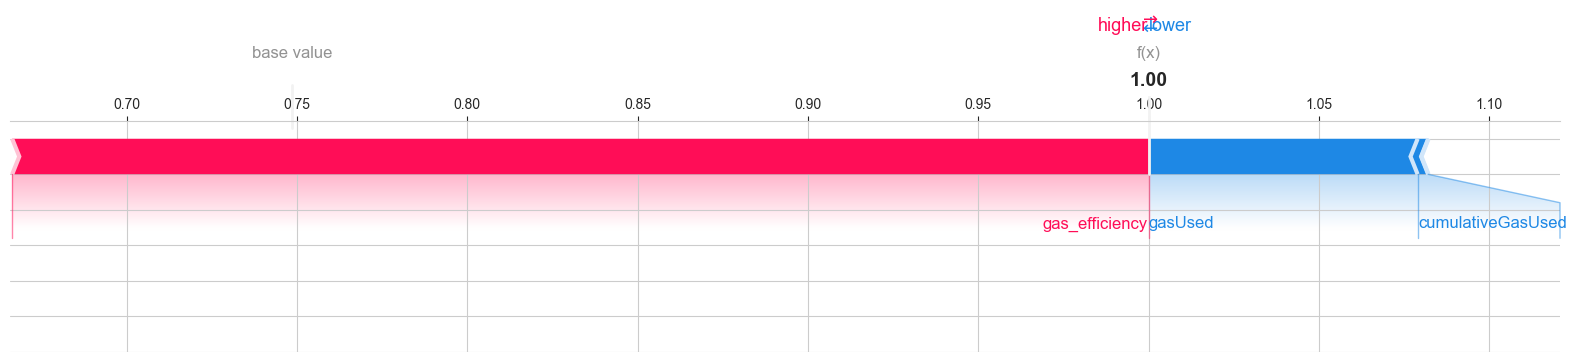

In [34]:
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Define features + target
features = ['gasUsed', 'gas_efficiency', 'complex_function', 'transactionIndex', 'cumulativeGasUsed']
X = df[features]
y = (df['ux_risk_score'] > 50).astype(int)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# SHAP Explainability
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Use correct SHAP output (handle binary/multiclass)
if isinstance(shap_values, list):
    shap_used = shap_values[1]  # class 1 (positive class)
    expected_val = explainer.expected_value[1]
else:
    shap_used = shap_values
    expected_val = explainer.expected_value

# 📊 Summary Bar Plot
shap.summary_plot(shap_used, X_test, plot_type="bar")

# 📊 Beeswarm Plot
shap.summary_plot(shap_used, X_test)







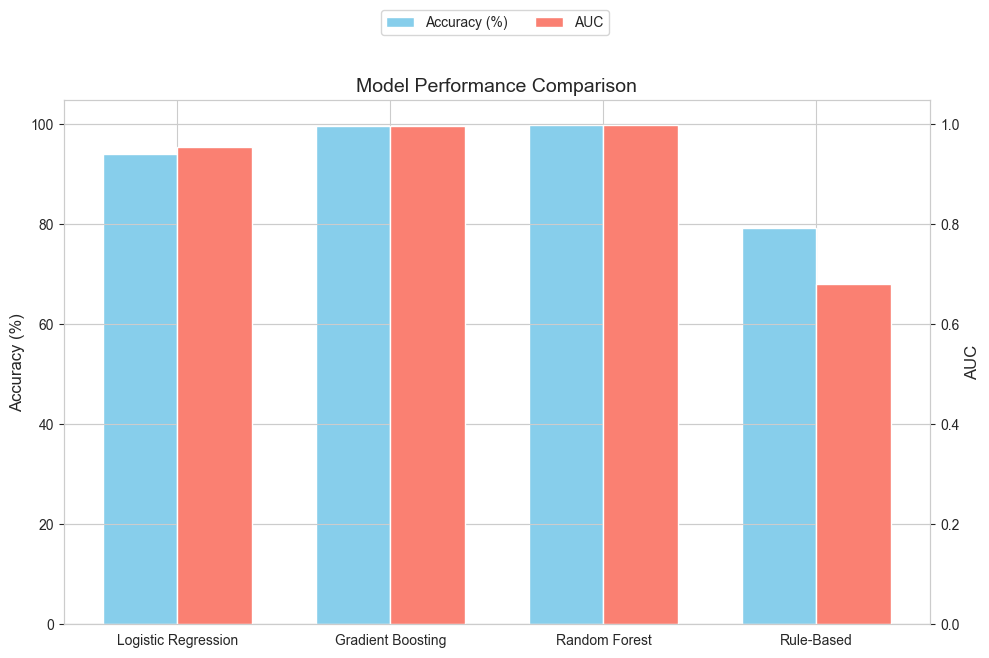

In [35]:
import matplotlib.pyplot as plt

# Accuracy and AUC data
models = ['Logistic Regression', 'Gradient Boosting', 'Random Forest', 'Rule-Based']
accuracy = [94.1, 99.6, 99.75, 79.2]
auc = [0.955, 0.997, 0.998, 0.68]  # assumed AUC for rule-based

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
bar_width = 0.35
x = range(len(models))

ax1.bar([i - bar_width/2 for i in x], accuracy, width=bar_width, color='skyblue', label='Accuracy (%)')
ax2.bar([i + bar_width/2 for i in x], auc, width=bar_width, color='salmon', label='AUC')

ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_ylabel('AUC', fontsize=12)
plt.xticks(ticks=x, labels=models, rotation=15)
plt.title("Model Performance Comparison", fontsize=14)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.tight_layout()
plt.show()


In [36]:
from scipy.stats import ttest_ind

low_eff = df[df['gas_efficiency'] < 0.5]['ux_risk_score']
high_eff = df[df['gas_efficiency'] >= 0.5]['ux_risk_score']

t_stat, p_val = ttest_ind(low_eff, high_eff)
print(f"T-statistic: {t_stat}, p-value: {p_val}")


T-statistic: 95.05248186655551, p-value: 0.0


<Figure size 640x480 with 0 Axes>

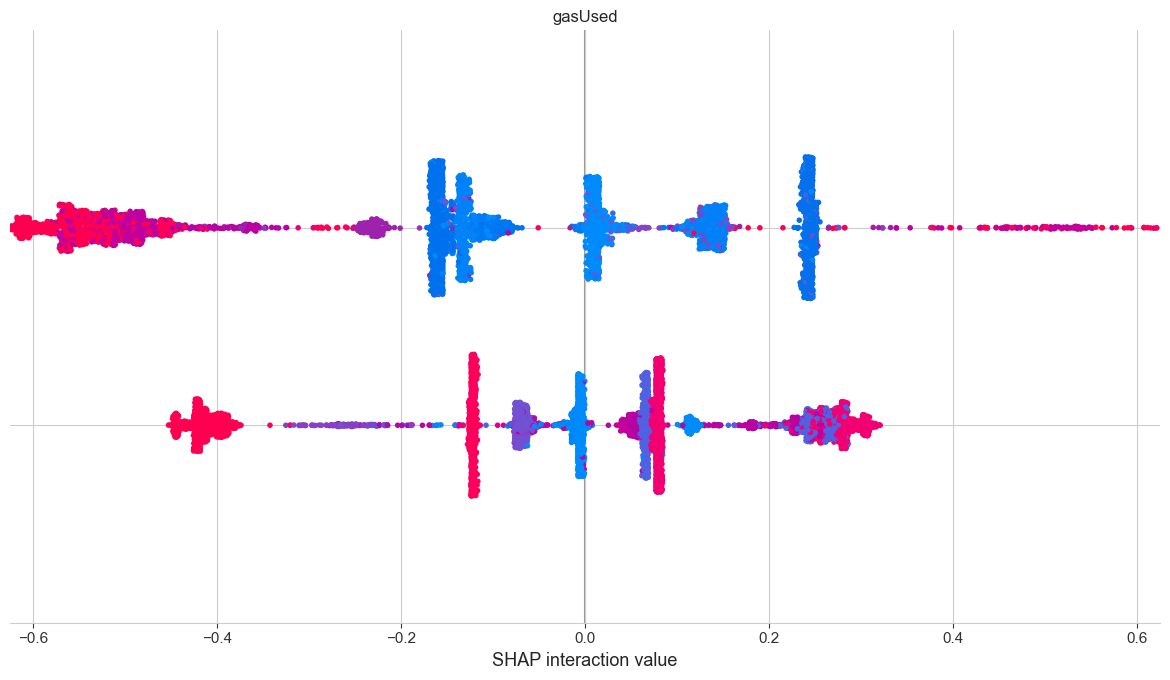

In [38]:
import shap
import matplotlib.pyplot as plt

# ✅ Assuming 'model' is your trained RandomForestClassifier
# ✅ And X_train is your training data

# Create a SHAP explainer for your model
explainer = shap.TreeExplainer(model)

# Compute SHAP values for training set
shap_values = explainer.shap_values(X_train)

# Extract SHAP values for the class (assumes binary classification, class index 1)
shap_used = shap_values[1] if isinstance(shap_values, list) else shap_values

# ✅ Plot SHAP Summary Bar Plot (Feature Importance)
plt.figure()
shap.summary_plot(shap_used, X_train, plot_type="bar", show=True)
